# Imports

In [1]:
import os
import cv2

from osgeo import gdal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

from PIL import Image

2023-05-23 03:38:15.506254: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 03:38:15.569375: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-23 03:38:15.570702: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-23 03:38:16.356188: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Connect to G-drive & assign working folder

In [1]:
from google.colab import drive
drive.mount('/gdrive')
!ln -s "/gdrive/My Drive/Colab Notebooks" "/content/Colab Notebooks"

Mounted at /gdrive


In [5]:
# Put Colab in the context of the project

# os.chdir allows you to change directories, like cd in the Terminal
os.chdir('/content/Colab Notebooks/project-solar-ai-solutions/AerialImageDataset')

In [ ]:
!pwd

/gdrive/My Drive/Colab Notebooks/project-solar-ai-solutions


# Testing folder paths

In [ ]:
def list_folder_tree(folder_path):
    for root, dirs, _ in os.walk(folder_path):
        if os.path.basename(root) != '.ipynb_checkpoints':
            level = root.replace(folder_path, '').count(os.sep)
            indent = ' ' * 4 * (level)
            print('{}{}/'.format(indent, os.path.basename(root)))

# Provide the path to your project data folder
folder_path = '/content/Colab Notebooks/project-solar-ai-solutions'

# Call the function to list the folder tree
list_folder_tree(folder_path)

project-solar-ai-solutions/
    AerialImageDataset/
        test/
            images/
        train/
            gt/
            images/
    AerialImageDataset_png/
        train/
            png_images/
            png_gt/
        test/
            png_images/


## Original geo-tiff Images

In [ ]:
image_path = 'AerialImageDataset/train/images/tyrol-w1.tif'
img_tif = load_img(image_path)
x_tif = img_to_array(img_tif) / 255.0  # Convert to NumPy array and normalize pixel values between 0 and 1

print("Shape of the array:", x_tif.shape)

Shape of the array: (5000, 5000, 3)


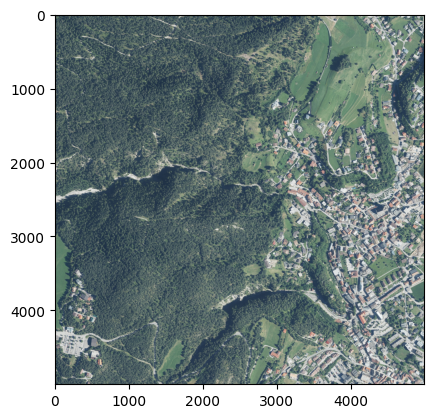

In [ ]:
plt.imshow(x_tif)

In [ ]:
image_path = 'AerialImageDataset/train/gt/tyrol-w1.tif'
gt = load_img(image_path)
x_gt = img_to_array(gt) / 255.0  # Convert to NumPy array and normalize pixel values between 0 and 1

print("Shape of the array:", x_gt.shape)

Shape of the array: (5000, 5000, 3)


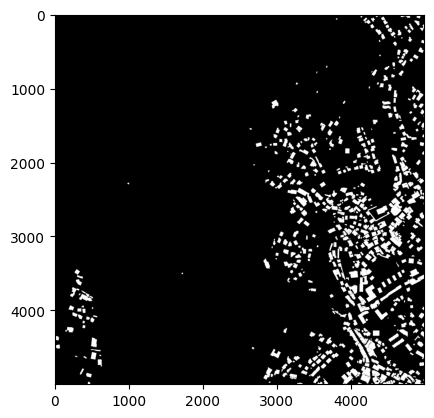

In [ ]:
plt.imshow(x_gt)

## Converted PNG Images

In [ ]:
image_path = 'AerialImageDataset_png/train/png_images/tyrol-w1.png'
img_png = load_img(image_path)
x_png = img_to_array(img_png) / 255.0  # Convert to NumPy array and normalize pixel values between 0 and 1

print("Shape of the array:", x_png.shape)

Shape of the array: (5000, 5000, 3)


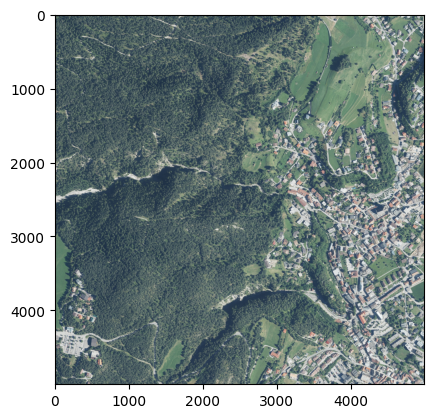

In [ ]:
plt.imshow(x_png)

In [ ]:
image_path = 'AerialImageDataset_png/train/png_gt/tyrol-w1.png'
gt_png = load_img(image_path)
x_gt_png = img_to_array(gt_png) / 255.0  # Convert to NumPy array and normalize pixel values between 0 and 1

print("Shape of the array:", x_gt_png.shape)

Shape of the array: (5000, 5000, 3)


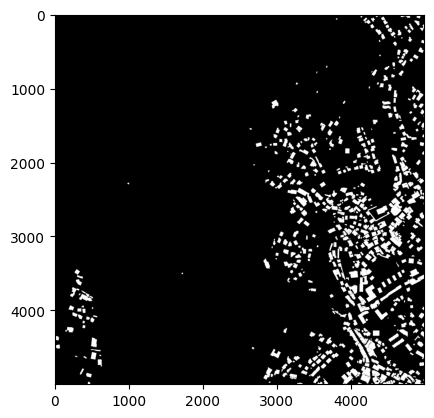

In [ ]:
plt.imshow(x_gt_png)

# Data load testing with gdal for geo-tiff images

In [ ]:
# Load GeoTIFF file
checking = gdal.Open('AerialImageDataset/train/images/tyrol-w1.tif',0)

In [ ]:
checking_gt = gdal.Open("AerialImageDataset/train/gt/tyrol-w1.tif",0)

In [ ]:
c_image = checking.ReadAsArray()
c_image.shape

(3, 5000, 5000)

In [ ]:
c_gt = checking_gt.ReadAsArray()
c_gt.shape

(5000, 5000)

In [ ]:
c_image = np.transpose(c_image,(1,2,0))
c_image.shape

(5000, 5000, 3)

In [ ]:
# c_gt = np.expand_dims(c_gt, axis=2)
# c_gt.shape

In [ ]:
# c_gt = cv2.cvtColor(c_gt,cv2.COLOR_BGR2RGB)

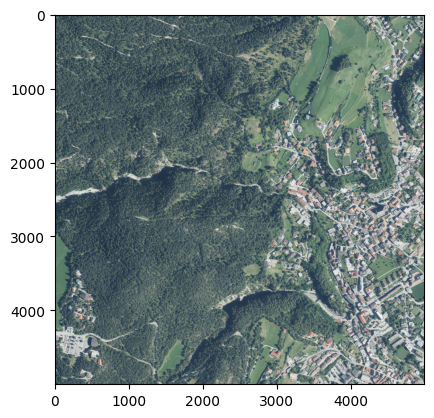

In [ ]:
plt.imshow(c_image)

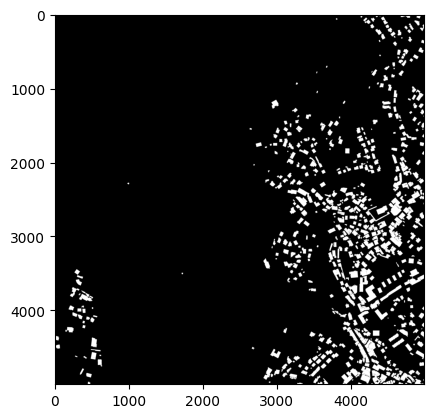

In [ ]:
plt.imshow(c_gt, cmap = 'gray')

In [ ]:
c_image = cv2.resize(c_image, (256, 256))

In [ ]:
c_gt = cv2.resize(c_gt, (256, 256))

In [ ]:
# c_gt = cv2.cvtColor(c_gt, cv2.COLOR_BGR2GRAY)

In [ ]:
c_image.shape

(256, 256, 3)

In [ ]:
c_gt.shape

(256, 256)

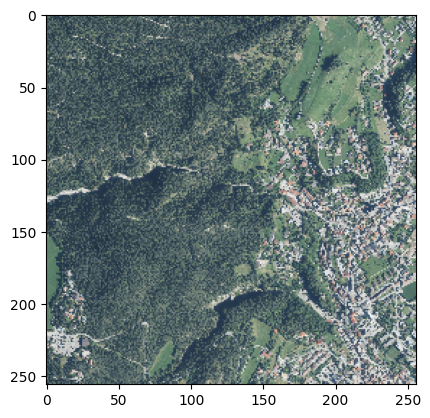

In [ ]:
plt.imshow(c_image)

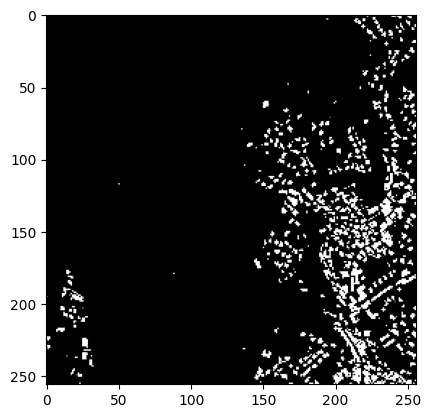

In [ ]:
plt.imshow(c_gt,cmap= 'gray')

In [ ]:
c_image = c_image / 255 # Normalize pixel values between 0 and 1

In [ ]:
c_gt = c_gt / 255 # Normalize pixel values between 0 and 1

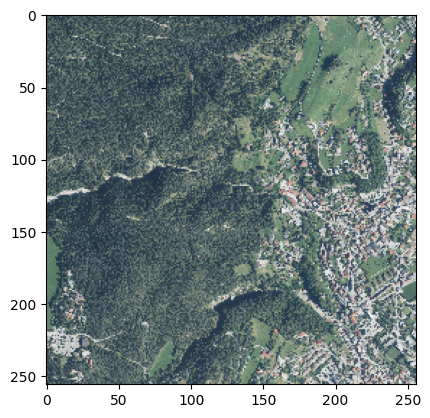

In [ ]:
plt.imshow(c_image)

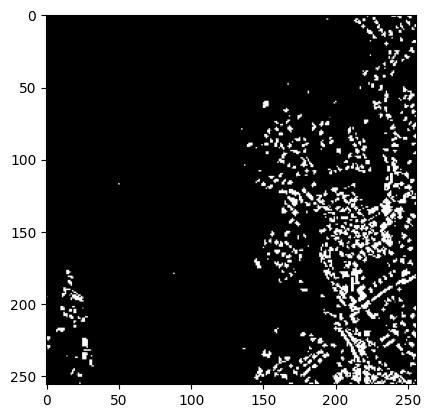

In [ ]:
plt.imshow(c_gt, cmap='gray')

# Data loading for all the files for execution

In [ ]:
# Folder containing GeoTIFF files, image data
image_data = 'AerialImageDataset/train/images'
batch_size = 64

# Function to load and preprocess GeoTIFF files
def load_geotiff_data(image_folder):
    file_paths = [os.path.join(image_folder, filename) for filename in sorted(os.listdir(image_folder)) if filename.endswith('.tif')]
    data = []
    for file_path in file_paths:
        dataset = gdal.Open(file_path,0)
        if dataset is None:
            continue
        image = dataset.ReadAsArray() # Convert to array
        image = np.transpose(image, (1,2,0))  # Transpose the position of channels in the image
        
        # Perform any necessary preprocessing steps here (e.g., resizing, normalization)
        image = cv2.resize(image, (256, 256)) # Re-shape / re-size the image: reducing image pixel from (5000, 5000) to (256, 256)
        image = image / 255 # Normalize pixel color values between 0 and 1 from 0 and 255

        # Add the preprocessed image to the data list
        data.append(image)
        dataset = None  # Close the dataset

    return np.array(data)

In [ ]:
# Load and preprocess GeoTIFF, image data as X
X_train = load_geotiff_data(image_data)

In [ ]:
X_train.shape

In [ ]:
plt.imshow(X_train[65])

In [ ]:
# Folder containing GeoTIFF files, gt data
gt_data = 'AerialImageDataset/train/gt'
batch_size = 64

# Function to load and preprocess GeoTIFF files
def load_geotiff_data(gt_folder):
    file_paths = [os.path.join(gt_folder, filename) for filename in sorted(os.listdir(gt_folder)) if filename.endswith('.tif')]
    data = []
    for file_path in file_paths:
        dataset = gdal.Open(file_path,0)

        if dataset is None:
            continue
        image = dataset.ReadAsArray() # Convert to array
        # image = np.expand_dims(image, axis=2)
        # image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)        
        
        # Perform any necessary preprocessing steps here (e.g., resizing, normalization)
        image = cv2.resize(image, (256, 256)) # Re-shape / re-size the image: reducing image pixel from (5000, 5000) to (256, 256)
        image = image / 255 # Normalize pixel color values between 0 and 1 from 0 and 255

        # Add the preprocessed image to the data list
        data.append(image)
        dataset = None  # Close the dataset

    return np.array(data)

In [ ]:
# Load and preprocess GeoTIFF, gt data as y
y_train = load_geotiff_data(gt_data)

In [ ]:
y_train.shape

In [ ]:
plt.imshow(y_train[65], cmap = 'gray')

In [ ]:
y_train = np.reshape(y_train, (-1, 1))

# Base Model (Testing)

In [ ]:
# Base CNN Model

def initialize_model():
    
    model = models.Sequential()
    
    model.add(layers.Conv2D(16, (5,5), input_shape=(256, 256, 3), padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(32, (4,4), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, (2,2), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(10, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    return model

In [ ]:
# Training the CNN

model = initialize_model()

model.summary()

In [ ]:
tensorflow.keras.utils.plot_model(model, "base_model.png", show_shapes=True)

In [ ]:
%%time

es = EarlyStopping(patience = 5,restore_best_weights=True)

# Fit the model on the train data
history = model.fit(
    X_train,
    y_train,
    validation_split = 0.2,
    epochs = 50,
    batch_size = 10, 
    verbose = 1, 
    callbacks = [es] # This will call the Early Stopping Criterion for each epoch
)

In [ ]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Test'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Test'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

In [ ]:
plot_loss_accuracy(history)